In [104]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, tensorflow as tf
import sys, time

In [105]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from timeVAE.vae_dense_model import VariationalAutoencoderDense as VAE_Dense
from timeVAE.vae_conv_model import VariationalAutoencoderConv as VAE_Conv
from timeVAE.vae_conv_I_model import VariationalAutoencoderConvInterpretable as TimeVAE
from timeVAE import utils
from sklearn.preprocessing import MinMaxScaler

In [106]:
MODEL = 1 # 0 = th v air, 1 = el v sky

In [107]:
index = [0,3] if MODEL==0 else [1,2]
model_name = 'th_v_air' if MODEL==0 else 'el_v_sky'

base_data_train, base_data_test = np.load('../../data/training_data/training_data_1month.npy', allow_pickle=True)
base_data_train, base_data_test = base_data_train[:,:,index], base_data_test[:,:,index] # 0,3 = th vs air; 1,2 = el vs sky
print(base_data_train.shape, base_data_test.shape)

(108, 730, 2) (12, 730, 2)


In [108]:
#print(base_data_train, base_data_test)

In [109]:
import tensorflow as tf

# Hide GPU from visible devices
tf.config.set_visible_devices([], 'GPU')
tf.config.get_visible_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

<h3> Scale data </h3>

In [110]:
from sklearn.preprocessing import MinMaxScaler

# Important to store each of the scalers we use for inverse transforming later
scalers = {var_name: MinMaxScaler(feature_range=(-1,1)) for var_name in ['G.air.T', 'G.E_th_I', 'month']}

temp_var, energy_var = base_data_train[:,:,0], base_data_train[:,:,1]
temp_var_test, energy_var_test = base_data_test[:,:,0], base_data_test[:,:,1]
#indicator_var, indicator_var_test = base_data_train[:,:,2], base_data_test[:,:,2]

temp_var = scalers['G.air.T'].fit_transform(temp_var)
energy_var = scalers['G.E_th_I'].fit_transform(energy_var)
#indicator_var = scalers['month'].fit_transform(indicator_var)

temp_var_test = scalers['G.air.T'].fit_transform(temp_var_test)
energy_var_test = scalers['G.E_th_I'].fit_transform(energy_var_test)
#indicator_var_test = scalers['month'].fit_transform(indicator_var_test)

scaled_data_train, scaled_data_test = np.stack((temp_var, energy_var), axis=-1), np.stack((temp_var_test, energy_var_test), axis=-1)
print(scaled_data_train.shape, scaled_data_test.shape)

(108, 730, 2) (12, 730, 2)


<h3> Build VAE </h3>

In [134]:
LATENT_DIM    = 10
LEARNING_RATE = 0.001
EPOCHS        = 1000
BATCH_SIZE    = 4


In [135]:
seq_len = base_data_train.shape[1]
feat_dim = base_data_train.shape[2]

hidden_layer_sizes = [64,128,64]

model = TimeVAE(seq_len=seq_len, 
                feat_dim=feat_dim, 
                latent_dim=LATENT_DIM, 
                hidden_layer_sizes=hidden_layer_sizes,
                use_scaler=False)

In [136]:
model.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_input (InputLayer)  [(None, 730, 2)]             0         []                            
                                                                                                  
 enc_conv_0 (Conv1D)         (None, 365, 64)              448       ['encoder_input[0][0]']       
                                                                                                  
 enc_conv_1 (Conv1D)         (None, 183, 128)             24704     ['enc_conv_0[0][0]']          
                                                                                                  
 enc_conv_2 (Conv1D)         (None, 92, 64)               24640     ['enc_conv_1[0][0]']          
                                                                                            

In [137]:
model.compile(optimizer=Adam(learning_rate=LEARNING_RATE), loss='loss')

<h3> Run VAE </h3>

In [138]:
early_stop = EarlyStopping(monitor='loss', patience=10, verbose=1, restore_best_weights=True)
reduce_lr  = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, verbose=1, restore_best_weight=True)

model.fit(scaled_data_train,
        epochs = EPOCHS,
        batch_size = BATCH_SIZE,
        shuffle = True,
        callbacks = [early_stop, reduce_lr],
        verbose = 1)

Epoch 1/1000
27/27 [==============================] - 3s 26ms/step - loss: 14057.3534 - reconstruction_loss: 3804.0410 - kl_loss: 58.8737 - lr: 0.0010
Epoch 2/1000
27/27 [==============================] - 1s 27ms/step - loss: 9027.6063 - reconstruction_loss: 2749.8704 - kl_loss: 149.8789 - lr: 0.0010
Epoch 3/1000
27/27 [==============================] - 1s 25ms/step - loss: 7515.1845 - reconstruction_loss: 2536.7263 - kl_loss: 103.3225 - lr: 0.0010
Epoch 4/1000
27/27 [==============================] - 1s 25ms/step - loss: 7771.7261 - reconstruction_loss: 2502.1797 - kl_loss: 73.3909 - lr: 0.0010
Epoch 5/1000
27/27 [==============================] - 1s 25ms/step - loss: 7589.1878 - reconstruction_loss: 2501.5388 - kl_loss: 61.4600 - lr: 0.0010
Epoch 6/1000
27/27 [==============================] - 1s 25ms/step - loss: 7479.8640 - reconstruction_loss: 2493.8591 - kl_loss: 53.6543 - lr: 0.0010
Epoch 7/1000
27/27 [==============================] - 1s 26ms/step - loss: 7497.4036 - reconstruc

[]

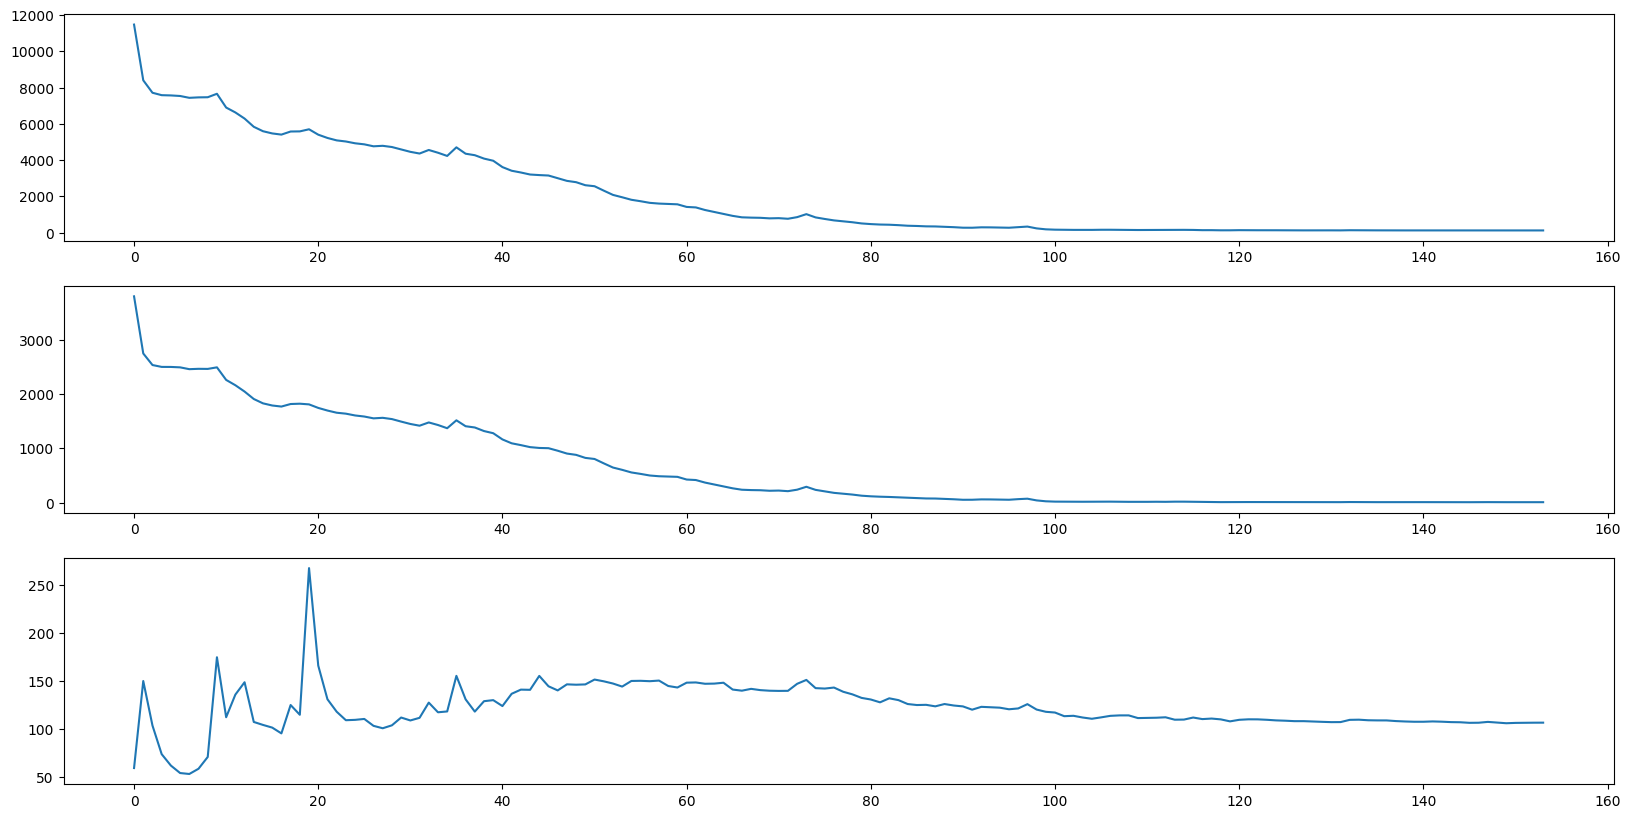

In [139]:
fig, ax = plt.subplots(3,1,figsize=(20,10))
ax[0].plot(model.history.history['loss'])
ax[1].plot(model.history.history['reconstruction_loss'])
ax[2].plot(model.history.history['kl_loss'])
plt.plot()

<h3> Generate synthetic samples </h3>

In [140]:
num_samples = 1000
generated_samples = model.get_prior_samples(num_samples=num_samples)
print(generated_samples.shape)

32/32 [==============================] - 0s 7ms/step
(1000, 730, 2)


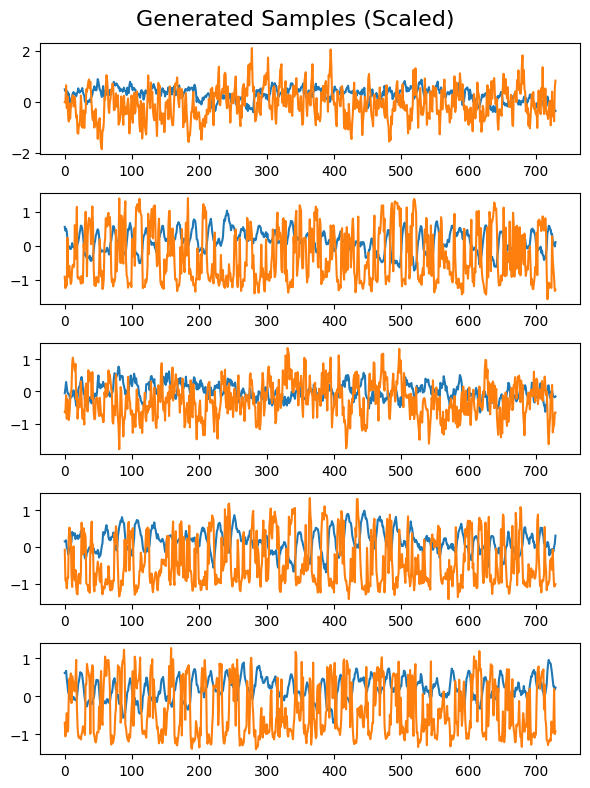

In [144]:
utils.plot_samples(generated_samples,n=5)

In [145]:
temp_var, energy_var = generated_samples[:,:,0], generated_samples[:,:,1]
temp_var, energy_var = scalers['G.air.T'].inverse_transform(temp_var), scalers['G.E_th_I'].inverse_transform(energy_var)

rescaled_samples = np.stack((temp_var, energy_var),axis=-1)

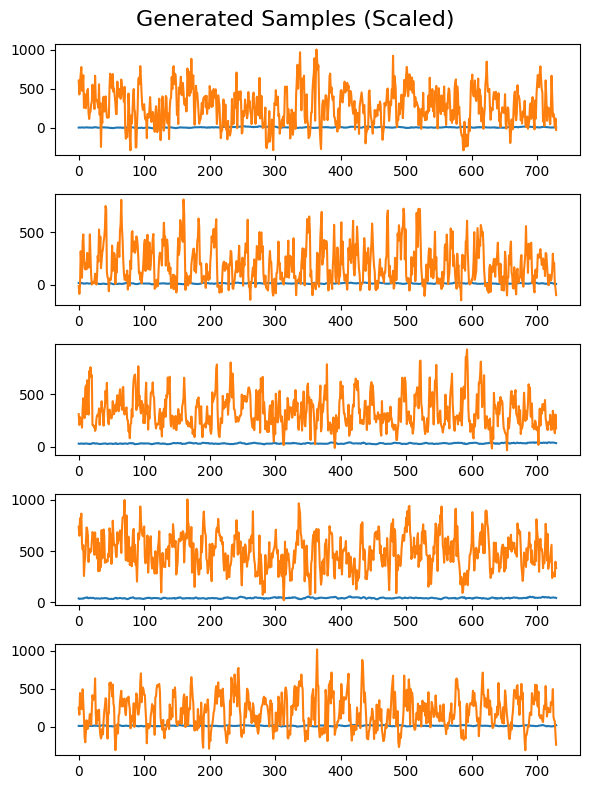

In [147]:
utils.plot_samples(rescaled_samples,n=5)

In [148]:
np.save(f'../../data/test_vae_data/{model_name}_generated_samples.npy', generated_samples)
np.save(f'../../data/test_vae_data/{model_name}_rescaled_samples.npy', rescaled_samples)

In [149]:
loss = pd.DataFrame(model.history.history)
loss.to_csv(f'../../data/test_vae_data/{model_name}_loss.csv')

In [168]:
percents = {}
for i, sample in enumerate(rescaled_samples):
    energy_var = sample[:,1]
    percents[f'{i}'] = np.mean(energy_var < 0)


In [170]:
from collections import OrderedDict

sorted_percents = OrderedDict(sorted(percents.items(), key=lambda item: item[1]))
print(sorted_percents)

OrderedDict([('11', 0.0), ('15', 0.0), ('22', 0.0), ('27', 0.0), ('41', 0.0), ('48', 0.0), ('54', 0.0), ('60', 0.0), ('97', 0.0), ('101', 0.0), ('104', 0.0), ('108', 0.0), ('125', 0.0), ('128', 0.0), ('145', 0.0), ('162', 0.0), ('164', 0.0), ('166', 0.0), ('178', 0.0), ('185', 0.0), ('191', 0.0), ('192', 0.0), ('196', 0.0), ('206', 0.0), ('211', 0.0), ('219', 0.0), ('226', 0.0), ('233', 0.0), ('234', 0.0), ('236', 0.0), ('255', 0.0), ('277', 0.0), ('295', 0.0), ('304', 0.0), ('316', 0.0), ('337', 0.0), ('370', 0.0), ('387', 0.0), ('389', 0.0), ('393', 0.0), ('436', 0.0), ('437', 0.0), ('450', 0.0), ('452', 0.0), ('453', 0.0), ('459', 0.0), ('474', 0.0), ('484', 0.0), ('488', 0.0), ('492', 0.0), ('519', 0.0), ('525', 0.0), ('536', 0.0), ('579', 0.0), ('580', 0.0), ('585', 0.0), ('591', 0.0), ('606', 0.0), ('615', 0.0), ('622', 0.0), ('646', 0.0), ('660', 0.0), ('663', 0.0), ('671', 0.0), ('676', 0.0), ('686', 0.0), ('693', 0.0), ('711', 0.0), ('717', 0.0), ('721', 0.0), ('733', 0.0), ('

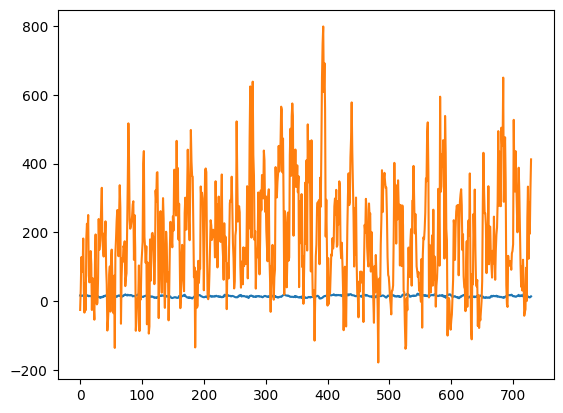

In [176]:
plt.plot(rescaled_samples[16])

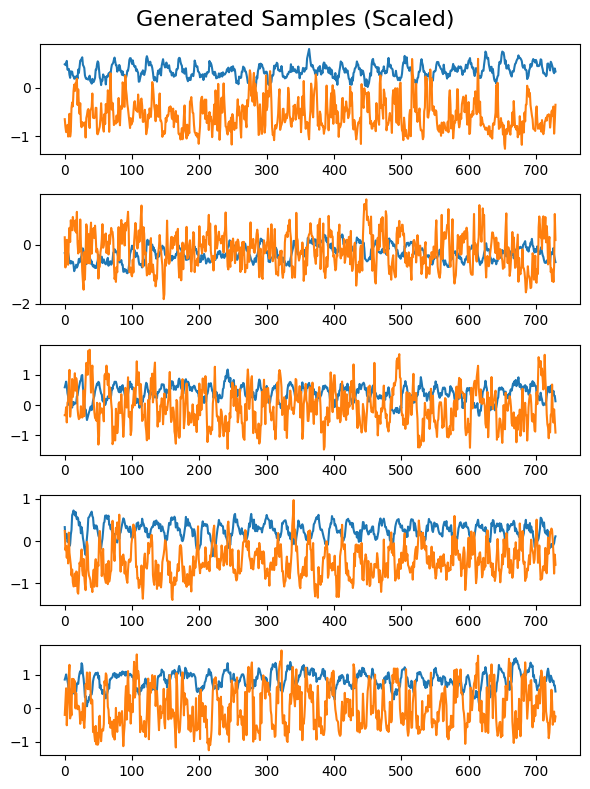

In [179]:
percentages = np.mean(rescaled_samples[:,:,1] < 0, axis=1)
mask = (percentages > 0) & (percentages < 0.1)
filtered_samples = generated_samples[mask]
filtered_rescaled_samples = rescaled_samples[mask]
utils.plot_samples(filtered_samples, n=5)

In [180]:
np.save(f'../../data/test_vae_data/{model_name}_filtered_samples.npy', filtered_samples)
np.save(f'../../data/test_vae_data/{model_name}_filtered_rescaled_samples.npy', filtered_rescaled_samples)

<h3> Hyperparameter tuning </h3>

In [115]:
latent_dims = [3,5,10,15, 20, 25, 30, 50]
batch_sizes = [4, 8, 16, 20, 24, 32]
learning_rates = [0.001]

losses = []
sample_list = []

seq_len = base_data_train.shape[1]
feat_dim = base_data_train.shape[2]

hidden_layer_sizes = [64,128,64]

for lr in learning_rates:
    for l_dim in latent_dims:
        for b_size in batch_sizes:
            vae = TimeVAE(seq_len=seq_len, 
                    feat_dim=feat_dim, 
                    latent_dim=l_dim, 
                    hidden_layer_sizes=hidden_layer_sizes,
                    use_scaler=False)

            vae.compile(optimizer=Adam(learning_rate=lr), loss='loss')

            early_stop = EarlyStopping(monitor='reconstruction_loss', patience=10, verbose=1, restore_best_weights=True)
            reduce_lr  = ReduceLROnPlateau(monitor='reconstruction_loss', factor=0.5, patience=5, verbose=1)

            print(f'Latent dimension: {l_dim}, Batch size: {b_size}')
            vae.fit(scaled_data_train,
                    epochs = 1000,
                    batch_size = b_size,
                    shuffle = True,
                    callbacks = [early_stop, reduce_lr],
                    verbose = 1)

            loss = pd.DataFrame(vae.history.history)
            loss.to_csv(f'../../data/models/model_data/{model_name}_l{l_dim}b{b_size}_hist.csv')
            losses.append(loss)

            #samples = vae.get_prior_samples(num_samples=1000)
            #np.save(f'../../data/models/model_data/{model_name}_l{l_dim}b{b_size}_samples.npy', samples)
            #sample_list.append(samples)

            #samples_temp_var, samples_energy_var = samples[:,:,0], samples[:,:,1]
            #samples_temp_var, samples_energy_var = scalers['G.air.T'].inverse_transform(samples_temp_var), \
            #    scalers['G.E_th_I'].inverse_transform(samples_energy_var)

            #scaled_samples = np.stack((samples_temp_var, samples_energy_var), axis=-1)
            #np.save(f'../../data/models/model_data/{model_name}_l{l_dim}b{b_size}_scaled_samples.npy', scaled_samples)

Latent dimension: 3, Batch size: 4
Epoch 1/1000
27/27 [==============================] - 4s 26ms/step - loss: 11822.5741 - reconstruction_loss: 3377.0381 - kl_loss: 87.1056 - lr: 0.0010
Epoch 2/1000
27/27 [==============================] - 1s 25ms/step - loss: 8556.2825 - reconstruction_loss: 2811.7629 - kl_loss: 132.7824 - lr: 0.0010
Epoch 3/1000
27/27 [==============================] - 1s 25ms/step - loss: 8132.2809 - reconstruction_loss: 2660.8157 - kl_loss: 120.3617 - lr: 0.0010
Epoch 4/1000
27/27 [==============================] - 1s 25ms/step - loss: 7918.4588 - reconstruction_loss: 2620.5156 - kl_loss: 64.7091 - lr: 0.0010
Epoch 5/1000
27/27 [==============================] - 1s 27ms/step - loss: 7876.5440 - reconstruction_loss: 2579.8157 - kl_loss: 60.1749 - lr: 0.0010
Epoch 6/1000
27/27 [==============================] - 1s 24ms/step - loss: 7614.4854 - reconstruction_loss: 2503.7612 - kl_loss: 71.2225 - lr: 0.0010
Epoch 7/1000
27/27 [==============================] - 1s 25ms/

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



4/4 [==============================] - 0s 42ms/step - loss: 54368.9023 - reconstruction_loss: 16444.2188 - kl_loss: 773.9486 - lr: 2.5000e-04
Epoch 78/1000
4/4 [==============================] - 0s 48ms/step - loss: 57728.1789 - reconstruction_loss: 16946.2715 - kl_loss: 739.8568 - lr: 2.5000e-04
Epoch 79/1000
4/4 [==============================] - 0s 46ms/step - loss: 55417.6125 - reconstruction_loss: 16445.3379 - kl_loss: 828.6503 - lr: 2.5000e-04
Epoch 80/1000
4/4 [==============================] - 0s 46ms/step - loss: 56398.4570 - reconstruction_loss: 16444.7852 - kl_loss: 866.8013 - lr: 2.5000e-04
Epoch 81/1000
4/4 [==============================] - 0s 53ms/step - loss: 56138.7039 - reconstruction_loss: 16424.5977 - kl_loss: 890.2122 - lr: 2.5000e-04
Epoch 82/1000
4/4 [==============================] - 0s 47ms/step - loss: 56381.0820 - reconstruction_loss: 16441.4961 - kl_loss: 904.7313 - lr: 2.5000e-04
Epoch 83/1000
4/4 [==============================] - 0s 48ms/step - loss: 5575

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Epoch 30/1000
7/7 [==============================] - 0s 24ms/step - loss: 10811.2566 - reconstruction_loss: 3428.5835 - kl_loss: 324.9420 - lr: 0.0010
Epoch 31/1000
7/7 [==============================] - 0s 23ms/step - loss: 10561.4709 - reconstruction_loss: 3333.0330 - kl_loss: 335.9630 - lr: 0.0010
Epoch 32/1000
7/7 [==============================] - 0s 23ms/step - loss: 10318.9375 - reconstruction_loss: 3148.3035 - kl_loss: 370.3817 - lr: 0.0010
Epoch 33/1000
7/7 [==============================] - 0s 23ms/step - loss: 9007.6512 - reconstruction_loss: 2796.6975 - kl_loss: 440.0807 - lr: 0.0010
Epoch 34/1000
7/7 [==============================] - 0s 23ms/step - loss: 8175.2894 - reconstruction_loss: 2528.7988 - kl_loss: 479.5559 - lr: 0.0010
Epoch 35/1000
7/7 [==============================] - 0s 23ms/step - loss: 7827.7477 - reconstruction_loss: 2380.2664 - kl_loss: 467.1364 - lr: 0.0010
Epoch 36/1000
7/7 [==============================] - 0s 23ms/step - loss: 7704.5206 - reconstruct

7/7 [==============================] - 0s 23ms/step - loss: 5416.4406 - reconstruction_loss: 1651.3459 - kl_loss: 338.4324 - lr: 0.0010
Epoch 85/1000
7/7 [==============================] - 0s 23ms/step - loss: 5362.2801 - reconstruction_loss: 1634.8190 - kl_loss: 338.9964 - lr: 0.0010
Epoch 86/1000
7/7 [==============================] - 0s 23ms/step - loss: 5221.6003 - reconstruction_loss: 1620.6156 - kl_loss: 325.1955 - lr: 0.0010
Epoch 87/1000
7/7 [==============================] - 0s 23ms/step - loss: 5199.9511 - reconstruction_loss: 1604.2922 - kl_loss: 314.5957 - lr: 0.0010
Epoch 88/1000
7/7 [==============================] - 0s 23ms/step - loss: 5147.7157 - reconstruction_loss: 1582.8002 - kl_loss: 311.0762 - lr: 0.0010
Epoch 89/1000
7/7 [==============================] - 0s 24ms/step - loss: 5110.5266 - reconstruction_loss: 1563.4425 - kl_loss: 340.8872 - lr: 0.0010
Epoch 90/1000
7/7 [==============================] - 0s 23ms/step - loss: 4996.7509 - reconstruction_loss: 1539.04

7/7 [==============================] - 0s 23ms/step - loss: 2558.4524 - reconstruction_loss: 730.7817 - kl_loss: 390.2907 - lr: 0.0010
Epoch 139/1000
7/7 [==============================] - 0s 23ms/step - loss: 2559.6997 - reconstruction_loss: 714.3322 - kl_loss: 404.1747 - lr: 0.0010
Epoch 140/1000
7/7 [==============================] - 0s 23ms/step - loss: 2600.8318 - reconstruction_loss: 702.1568 - kl_loss: 394.9710 - lr: 0.0010
Epoch 141/1000
7/7 [==============================] - 0s 23ms/step - loss: 2440.7905 - reconstruction_loss: 690.1844 - kl_loss: 383.5697 - lr: 0.0010
Epoch 142/1000
7/7 [==============================] - 0s 23ms/step - loss: 2285.6026 - reconstruction_loss: 667.5875 - kl_loss: 385.3652 - lr: 0.0010
Epoch 143/1000
7/7 [==============================] - 0s 23ms/step - loss: 2606.0992 - reconstruction_loss: 663.2336 - kl_loss: 395.8613 - lr: 0.0010
Epoch 144/1000
7/7 [==============================] - 0s 23ms/step - loss: 2422.4985 - reconstruction_loss: 636.555

7/7 [==============================] - 0s 24ms/step - loss: 1198.2595 - reconstruction_loss: 246.6645 - kl_loss: 421.0755 - lr: 5.0000e-04
Epoch 191/1000
7/7 [==============================] - 0s 23ms/step - loss: 1166.4073 - reconstruction_loss: 239.8984 - kl_loss: 420.7869 - lr: 5.0000e-04
Epoch 192/1000
7/7 [==============================] - 0s 23ms/step - loss: 1110.8414 - reconstruction_loss: 235.7083 - kl_loss: 423.6016 - lr: 5.0000e-04
Epoch 193/1000
7/7 [==============================] - 0s 23ms/step - loss: 1215.8950 - reconstruction_loss: 235.1147 - kl_loss: 432.4157 - lr: 5.0000e-04
Epoch 194/1000
7/7 [==============================] - 0s 23ms/step - loss: 1110.6131 - reconstruction_loss: 222.6080 - kl_loss: 433.4638 - lr: 5.0000e-04
Epoch 195/1000
7/7 [==============================] - 0s 23ms/step - loss: 1154.7228 - reconstruction_loss: 223.3955 - kl_loss: 424.7802 - lr: 5.0000e-04
Epoch 196/1000
7/7 [==============================] - 0s 23ms/step - loss: 1069.6648 - reco

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [154]:
model.get_prior_samples(num_samples=5).shape #vae.get_prior_samples(num_samples=5).shape

1/1 [==============================] - 0s 28ms/step


(5, 730, 2)

In [122]:
latent_dims = [3, 5, 10, 15, 20, 25, 30, 50]
batch_sizes = [4, 8, 16, 20, 24, 32]

min_loss = 10000

for l_dim in latent_dims:
    for b_size in batch_sizes:
        loss = pd.read_csv(f'../../data/models/model_data/{model_name}_l{l_dim}b{b_size}_hist.csv')
        if loss['loss'].min() < min_loss:
            min_loss = loss['loss'].min()
            print(f'{l_dim}, {b_size}: {loss["loss"].min()}')

3, 4: 75.93746185302734


In [123]:
for l_dim in latent_dims:
    for b_size in batch_sizes:
        loss = pd.read_csv(f'../../data/models/model_data/{model_name}_l{l_dim}b{b_size}_hist.csv')
        print(f'{l_dim}, {b_size}: {np.round(loss["loss"].min(),4)}')

3, 4: 75.9375
3, 8: 137.2632
3, 16: 387.2905
3, 20: 730.5813
3, 24: 939.79
3, 32: 2954.9016
5, 4: 93.8123
5, 8: 213.5308
5, 16: 348.6896
5, 20: 527.7785
5, 24: 580.5933
5, 32: 956.3348
10, 4: 126.2331
10, 8: 263.035
10, 16: 562.3469
10, 20: 644.5554
10, 24: 850.5818
10, 32: 1152.3141
15, 4: 148.3803
15, 8: 307.949
15, 16: 672.9916
15, 20: 793.0825
15, 24: 1014.4664
15, 32: 1407.4602
20, 4: 182.6735
20, 8: 425.3127
20, 16: 820.1219
20, 20: 1027.2334
20, 24: 1163.7859
20, 32: 1485.9512
25, 4: 184.7602
25, 8: 432.0826
25, 16: 850.684
25, 20: 1160.141
25, 24: 1402.7371
25, 32: 2433.8962
30, 4: 207.5317
30, 8: 506.0037
30, 16: 899.2568
30, 20: 1375.5504
30, 24: 1734.8059
30, 32: 3164.9341
50, 4: 261.0681
50, 8: 493.4265
50, 16: 1734.526
50, 20: 1427.7262
50, 24: 3827.4265
50, 32: 4656.085


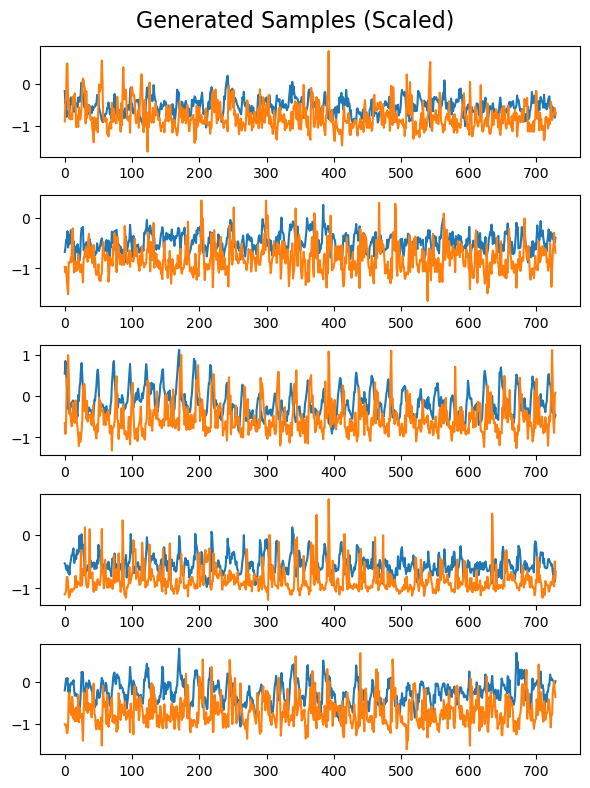

In [30]:
samples = np.load(f'../../data/models/model_data/{model_name}_l3b4_samples.npy')
utils.plot_samples(samples, n=5)

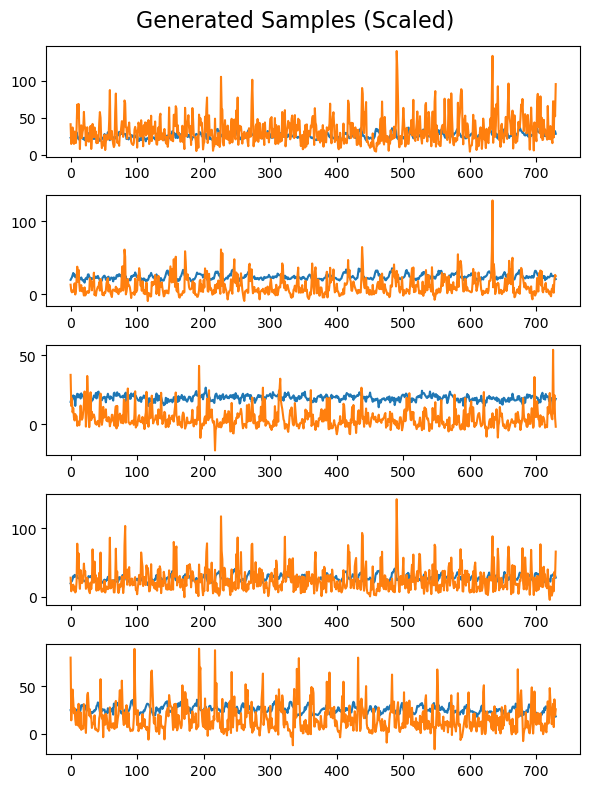

In [28]:
samples = np.load(f'../../data/models/model_data/{model_name}_l3b4_scaled_samples.npy')
utils.plot_samples(samples, n=5)

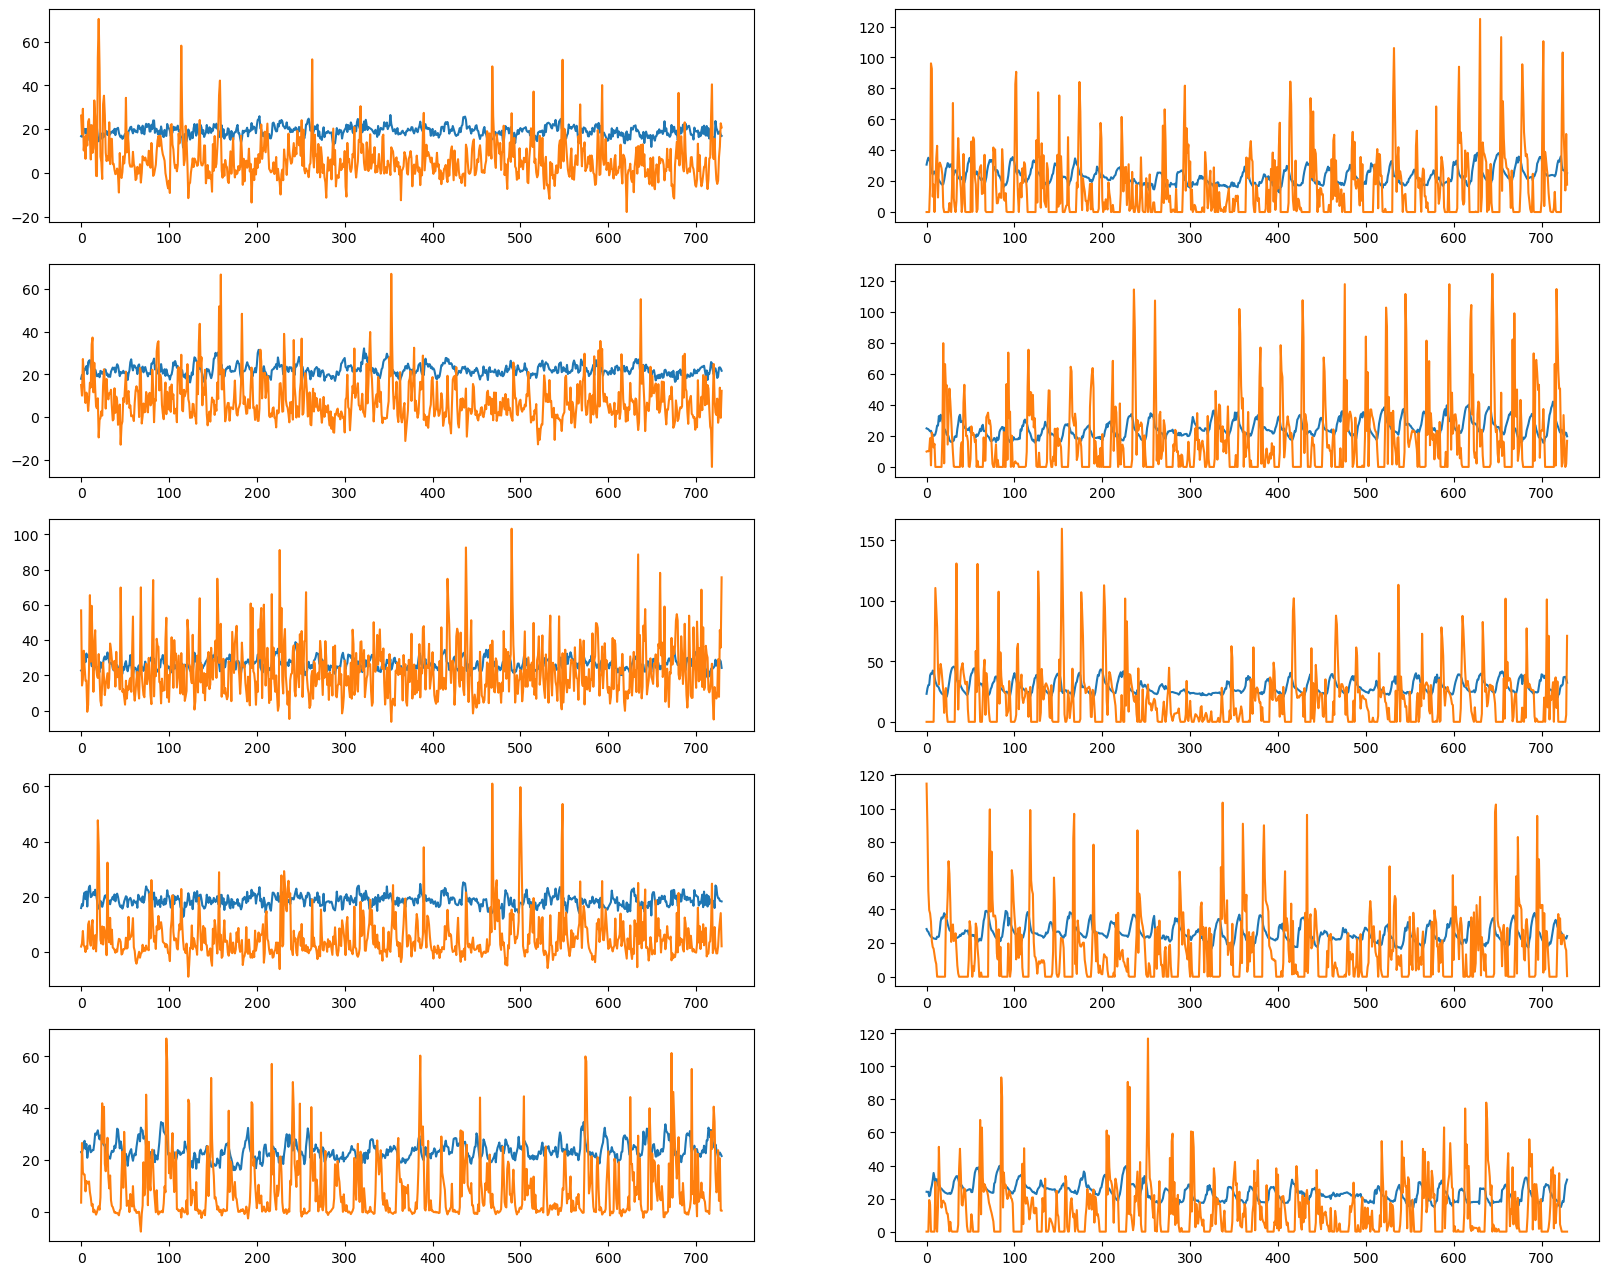

In [26]:
offset = 100
fig, ax = plt.subplots(5, 2, figsize=(20,16))
for i in range(5):
    ax[i,0].plot(samples[i+offset,:])
    ax[i,1].plot(base_data_train[i+offset,:])

Synthetic samples are starting to look a lot better. However negative energy values are impossible. To solve this we can simply truncate all values below 0, or we can shift the values up to be above 0. We can even combine the two approaches as below. (or we can ignore it and hope it doesn't affect evaluation)

In [114]:
scaled_sample = scaled_sample_list[0].copy()

sub_zero_vals = scaled_sample[:,:,1][scaled_sample[:,:,1] < 0]
sub_zero99 = np.percentile(sub_zero_vals, 20)

print(sub_zero99)
scaled_sample[:,:,1] += abs(sub_zero99)

-3.0234012603759766


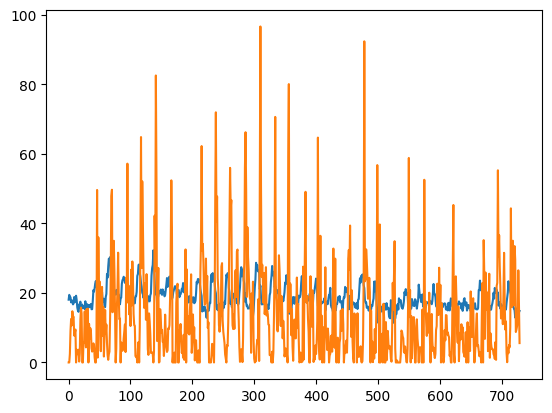

In [116]:
scaled_sample = np.where(scaled_sample < 0, 0, scaled_sample)
plt.plot(scaled_sample[0])

In [122]:
np.save('../data/th_v_air_sample.npy',scaled_sample)#_list[0])

<h3> Selecting the best model </h3>

3, 16:	1206.52490234375, 147.5886993408203
	1206.52490234375, 142.17529296875



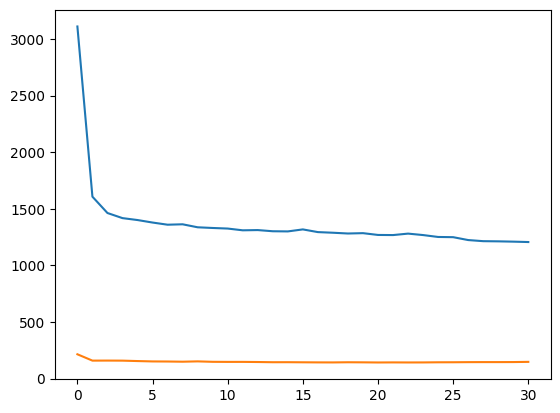

5, 16:	1082.133056640625, 214.4638519287109
	1082.133056640625, 197.25733947753903



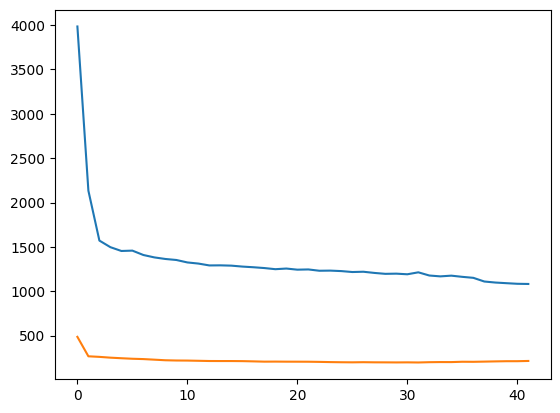

In [208]:
latent_dims = [3,5]
batch_sizes = [16]#,24,32]
min_loss = 1000

for l_dim in latent_dims:
    for b_size in batch_sizes:
        loss = pd.read_csv(f'../data/tuning/junkrun1/lr0.001l{l_dim}b{b_size}_hist.csv')
        print(f'{l_dim}, {b_size}:\t{loss["reconstruction_loss"].iloc[-1]}, {loss["kl_loss"].iloc[-1]}')
        
        print(f'\t{loss["reconstruction_loss"].min()}, {loss["kl_loss"].min()}\n')
        plt.plot(loss[["reconstruction_loss", "kl_loss"]])
        plt.show()

(1000, 730, 3) (1000, 730, 3)


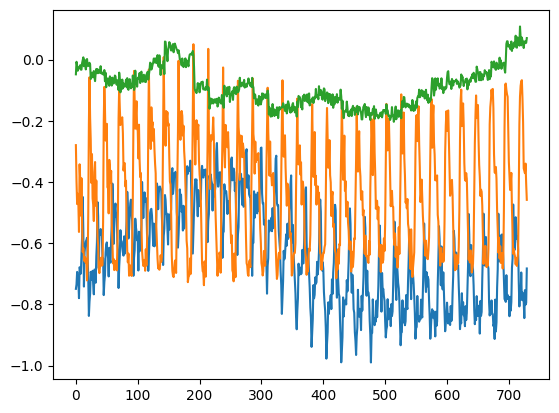

In [205]:
samples = np.load('../data/tuning/junkrun1/lr0.001l3b16_samples.npy')
scaled_samples = np.load('../data/tuning/junkrun1/lr0.001l3b16_scaled_samples.npy')
print(samples.shape, scaled_samples.shape)
plt.plot(samples[2,:])

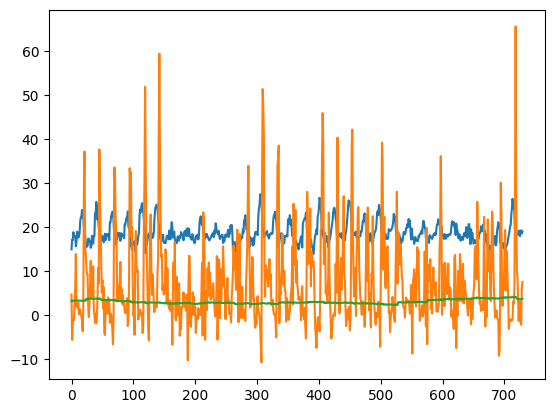

In [418]:
plt.plot(rescaled_samples[2,:])

In [378]:
reshaped_sample = scaled_samples.reshape(-1, 3)
print(pd.DataFrame(reshaped_sample, columns=['G.air.T', 'G.E_th_I', 'month']).describe())

             G.air.T       G.E_th_I          month
count  730000.000000  730000.000000  730000.000000
mean       19.788651      10.604332       6.386692
std         4.279791      10.048422       2.895654
min        -3.002542     -42.836674      -2.924322
25%        17.282743       3.230851       4.175731
50%        19.039019       8.354959       6.296662
75%        21.934312      14.714235       8.583144
max        39.231400      80.863464      15.535751


<h3> Create datasets for testing strategies </h3>

Must create:
 - Purely synthetic dataset
 - Synthetic runs into real data
 - Synthetic-Real blended dataset

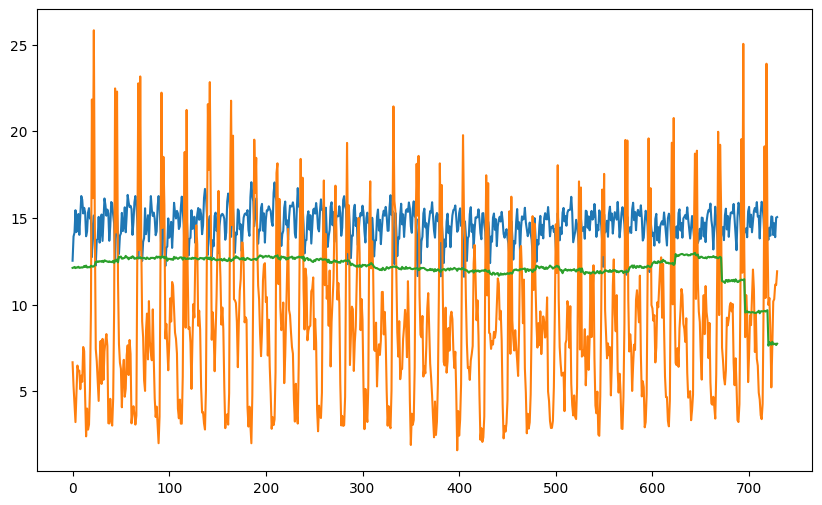

In [217]:
i = 656

plt.figure(figsize=(10,6))
plt.plot(scaled_samples[i,:])
plt.show()

In [285]:
means = np.mean(scaled_samples[:,:,2],axis=1)
sorted_means, sorted_i = np.sort(np.rint(means)), np.argsort(np.rint(means))

for i in range(len(sorted_i)):
    print(f'{sorted_i[i]}: {sorted_means[i]}')

259: -2.0
824: -1.0
272: -0.0
714: 0.0
52: -0.0
956: 0.0
276: 1.0
605: 1.0
600: 1.0
645: 1.0
23: 1.0
926: 1.0
34: 1.0
554: 1.0
221: 1.0
523: 1.0
584: 1.0
654: 1.0
237: 1.0
415: 1.0
16: 1.0
282: 1.0
777: 2.0
539: 2.0
94: 2.0
766: 2.0
763: 2.0
818: 2.0
129: 2.0
558: 2.0
569: 2.0
826: 2.0
734: 2.0
683: 2.0
681: 2.0
163: 2.0
187: 2.0
869: 2.0
536: 2.0
762: 2.0
499: 2.0
545: 2.0
477: 2.0
463: 2.0
262: 2.0
985: 2.0
296: 2.0
954: 2.0
521: 2.0
448: 2.0
37: 2.0
935: 2.0
712: 3.0
705: 3.0
691: 3.0
717: 3.0
401: 3.0
719: 3.0
398: 3.0
737: 3.0
235: 3.0
385: 3.0
393: 3.0
404: 3.0
351: 3.0
347: 3.0
342: 3.0
340: 3.0
124: 3.0
123: 3.0
338: 3.0
788: 3.0
753: 3.0
334: 3.0
281: 3.0
168: 3.0
527: 3.0
232: 3.0
230: 3.0
524: 3.0
222: 3.0
111: 3.0
470: 3.0
561: 3.0
573: 3.0
579: 3.0
200: 3.0
454: 3.0
194: 3.0
603: 3.0
433: 3.0
422: 3.0
610: 3.0
619: 3.0
632: 3.0
173: 3.0
420: 3.0
238: 3.0
661: 3.0
414: 3.0
800: 3.0
161: 3.0
54: 3.0
942: 3.0
76: 3.0
90: 3.0
89: 3.0
974: 3.0
983: 3.0
42: 3.0
885: 3.0
886: 3.0

In [304]:
year_samples = []

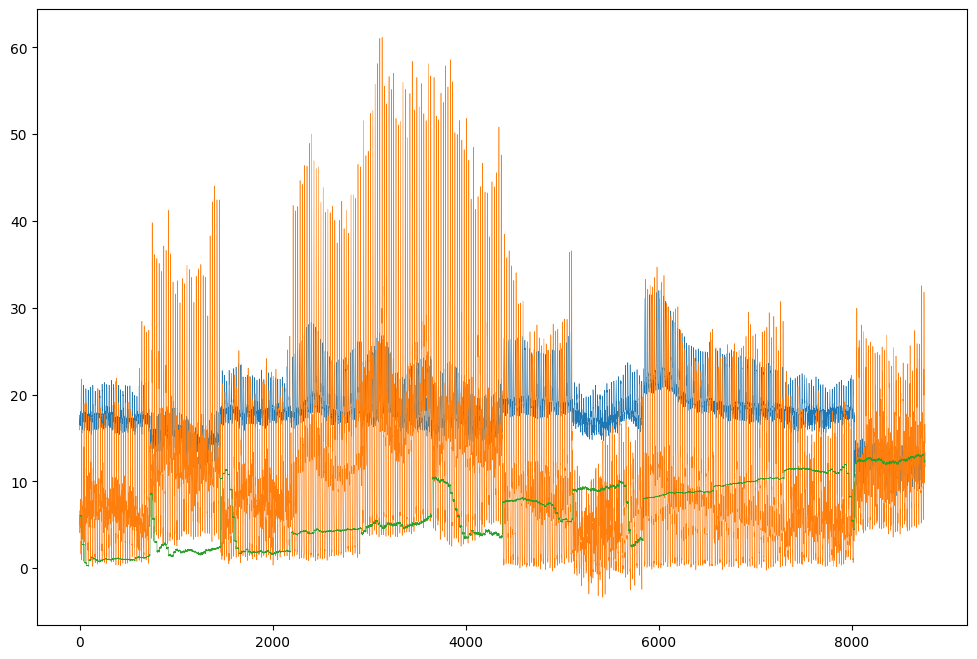

In [350]:
import random

sorted_means = {}
for i, mean in enumerate(np.rint(means)):
    if mean not in sorted_means:
        sorted_means[mean] = []
    sorted_means[mean].append(i)

target_means = np.arange(1,13)

selected_samples = []
for target in target_means:
    #samples_in_month = sorted_means[target]
    #print(target, len(samples_in_month))

    selected_sample = random.choice(sorted_means[target])
    selected_samples.append(scaled_samples[selected_sample])

plt.figure(figsize=(12,8))
plt.plot(np.concatenate(selected_samples, axis=0), linewidth=0.4)

In [351]:
year_samples.append(np.concatenate(selected_samples, axis=0))
print(len(year_samples))

10


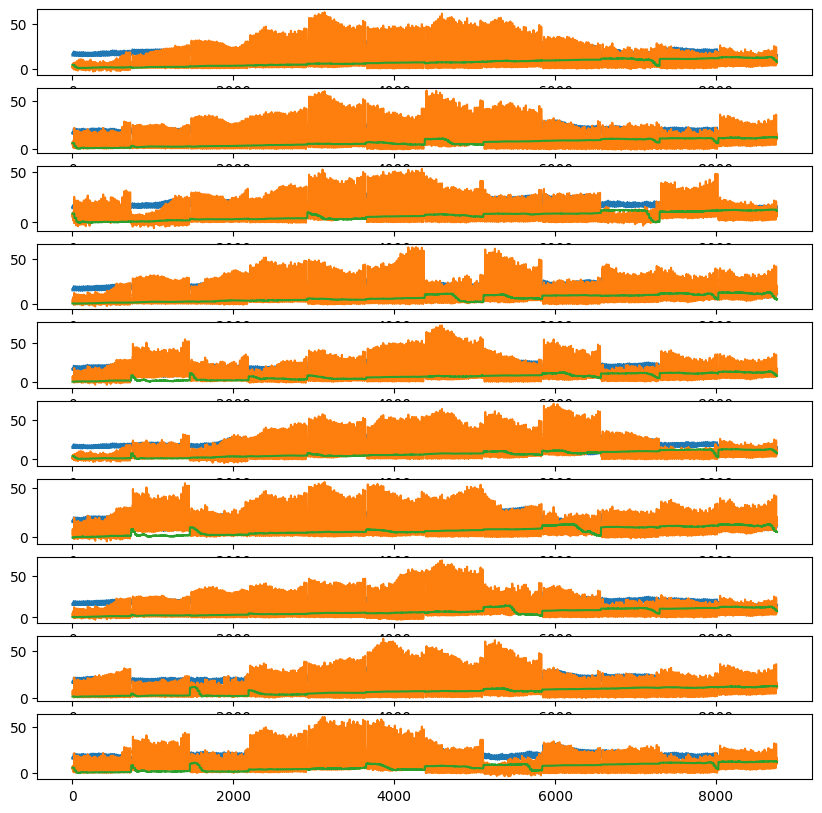

In [354]:
fig, ax = plt.subplots(10,1,figsize=(10,10))
for i in range(10):
    ax[i].plot(year_samples[i])

plt.show()